In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [ ]:
def potencia(imagem, c, y):
    altura, largura = imagem.shape[:2]
    result = np.empty_like(imagem)
    for i in range(altura):
        for j in range(largura):
            result[i, j] = c*(imagem[i, j] ** y)
    return result


class potencia_torch(object):
    
    def __init__(self, c, y) -> None:
        self.c = c
        self.y = y
    
    def __call__(self, imagem):
        altura, largura = imagem.shape[:2]
        result = np.empty_like(imagem)
        for i in range(altura):
            for j in range(largura):
                result[i, j] = self.c*(imagem[i, j] ** self.y)
        return result


In [ ]:
transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1), transforms.ToTensor(), potencia_torch(1,0.4)])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=6,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=6,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


0.5
0.9952605
(3, 36, 206)


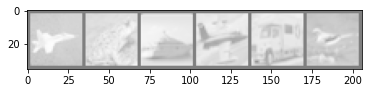

plane  frog  ship plane


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(np.min(npimg))
    print(np.max(npimg))
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap="gray")
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

img_transform = images[0]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class classificador(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3))
    self.conv2 = nn.Conv2d(32, 32, (3, 3))
    self.activation = nn.ReLU()
    self.bnorm = nn.BatchNorm2d(num_features=32)
    self.pool = nn.MaxPool2d(kernel_size = (2,2))
    self.flatten = nn.Flatten()

    # output = (input - filter + 1) / stride
    # convolução 1: (28 - 3 + 1) / 1 = 30x30
    # pooling 1: 15x15
    # convolução 2: (15 - 3 + 1) / 1 = 13x13
    # pooling 2: 6x6
    # 6 * 6 * 32
    # 800 -> 128 -> 128 -> 10
    self.linear1 = nn.Linear(in_features=32*6*6, out_features=128)
    self.linear2 = nn.Linear(128, 128)
    self.output = nn.Linear(128, 10)
    self.dropout = nn.Dropout(p = 0.2)

  def forward(self, X):
    X = self.pool(self.bnorm(self.activation(self.conv1(X))))
    X = self.pool(self.bnorm(self.activation(self.conv2(X))))
    X = self.flatten(X)

    X = self.dropout(self.activation(self.linear1(X)))
    X = self.dropout(self.activation(self.linear2(X)))
    X = self.output(X)

    return X


net = classificador()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.866
[1,  4000] loss: 1.579
[1,  6000] loss: 1.451
[1,  8000] loss: 1.380
[2,  2000] loss: 1.253
[2,  4000] loss: 1.234
[2,  6000] loss: 1.198
[2,  8000] loss: 1.186
[3,  2000] loss: 1.088
[3,  4000] loss: 1.088
[3,  6000] loss: 1.066
[3,  8000] loss: 1.075
[4,  2000] loss: 0.987
[4,  4000] loss: 0.994
[4,  6000] loss: 0.999
[4,  8000] loss: 0.996
[5,  2000] loss: 0.905
[5,  4000] loss: 0.915
[5,  6000] loss: 0.929
[5,  8000] loss: 0.949
Finished Training


0.5
0.9984276
(3, 36, 206)


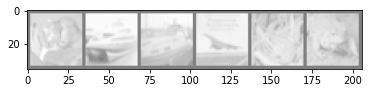

GroundTruth:    cat  ship  ship plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   frog   car  ship plane


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 62 %


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 76 %
Accuracy of   car : 78 %
Accuracy of  bird : 42 %
Accuracy of   cat : 31 %
Accuracy of  deer : 61 %
Accuracy of   dog : 58 %
Accuracy of  frog : 69 %
Accuracy of horse : 68 %
Accuracy of  ship : 68 %
Accuracy of truck : 71 %
